In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
np.random.seed(45)
num_samples = 40

# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps
X, Y = np.meshgrid(x1, y)
x1_torch = torch.tensor(x1, device = device)
y_torch = torch.tensor(y, device = device)

# Use $torch.autograd$

In [79]:
theta0 = torch.tensor(0.0, requires_grad=True, device = device)
theta1 = torch.tensor(0.0, requires_grad=True, device = device)
lin_reg = theta0 + theta1 * x1_torch
loss = torch.mean((lin_reg - y_torch)**2)
loss.backward()
print(f'Loss: {loss.item()}')
print(f'Theta0: {theta0.grad.item()}')
print(f'Theta1: {theta1.grad.item()}')

Loss: 16.681486003243624
Theta0: -7.447053909301758
Theta1: -1.0253016948699951


# Stochastic Gradient

In [50]:
theta0 = torch.tensor(0.0, requires_grad=True, device = device)
theta1 = torch.tensor(0.0, requires_grad=True, device = device)
stochastic_gradients_theta0 = []
stochastic_gradients_theta1 = []
for i in range(len(x1_torch)):
    pred = theta1*x1_torch[i] + theta0
    loss_single = (pred-y_torch[i])**2
    loss_single.backward()
    stochastic_gradients_theta0.append(theta0.grad.item())
    stochastic_gradients_theta1.append(theta1.grad.item())
    theta0.grad.zero_()
    theta1.grad.zero_()
stochastic_gradients_theta0 = torch.tensor(stochastic_gradients_theta0).mean()
stochastic_gradients_theta1 = torch.tensor(stochastic_gradients_theta1).mean()


print(f'Loss: {loss_single.item()}')
print(f"Average Stochastic Gradient for θ0: {stochastic_gradients_theta0.item()}")
print(f"Average Stochastic Gradient for θ1: {stochastic_gradients_theta1.item()}\n")

Loss: 5.352800910343222
Average Stochastic Gradient for θ0: -7.4470534324646
Average Stochastic Gradient for θ1: -1.0253016948699951



# Gradient Descent Implementation


##### Optimal Theta

In [81]:
X = np.column_stack((np.ones(num_samples), x1))

# Convert to PyTorch tensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_torch = torch.tensor(X, dtype=torch.float32, device=device)
y_torch = torch.tensor(y, dtype=torch.float32, device=device)

# Compute optimal theta using the normal equation
optimal_theta = torch.matmul(
    torch.linalg.inv(torch.matmul(X_torch.transpose(0, 1), X_torch)),
    torch.matmul(X_torch.transpose(0, 1), y_torch)
)

print(optimal_theta)

tensor([3.9507, 2.6825], device='cuda:0')


#### Implementation

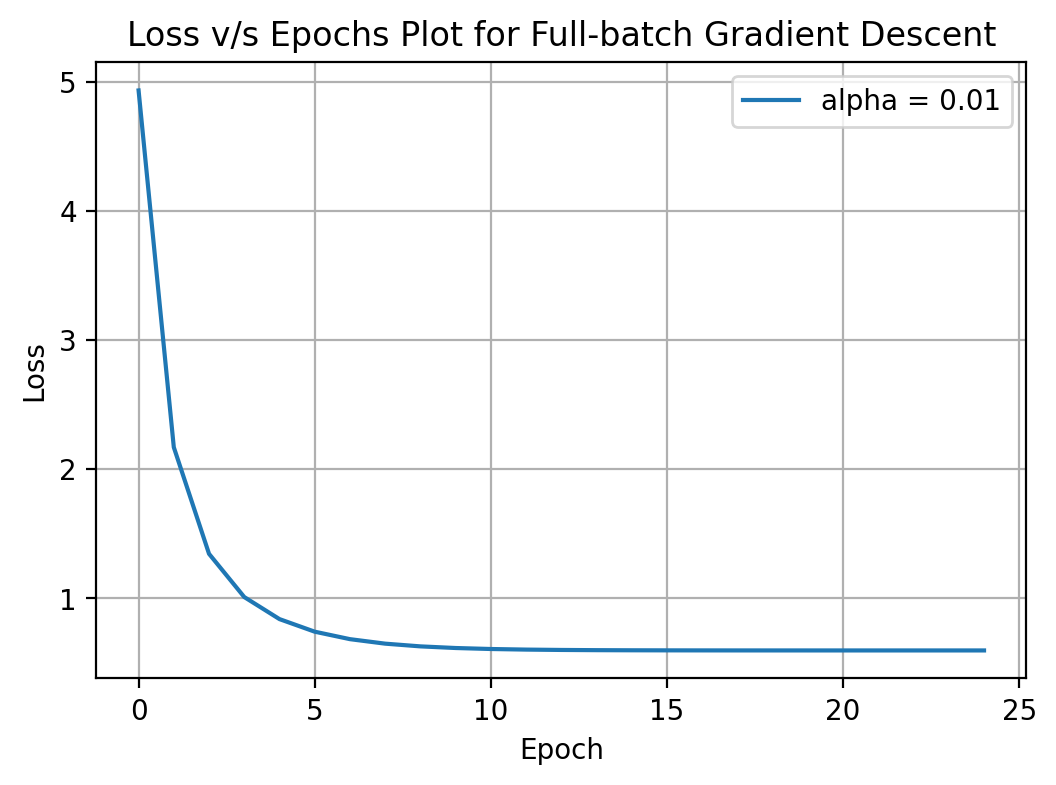

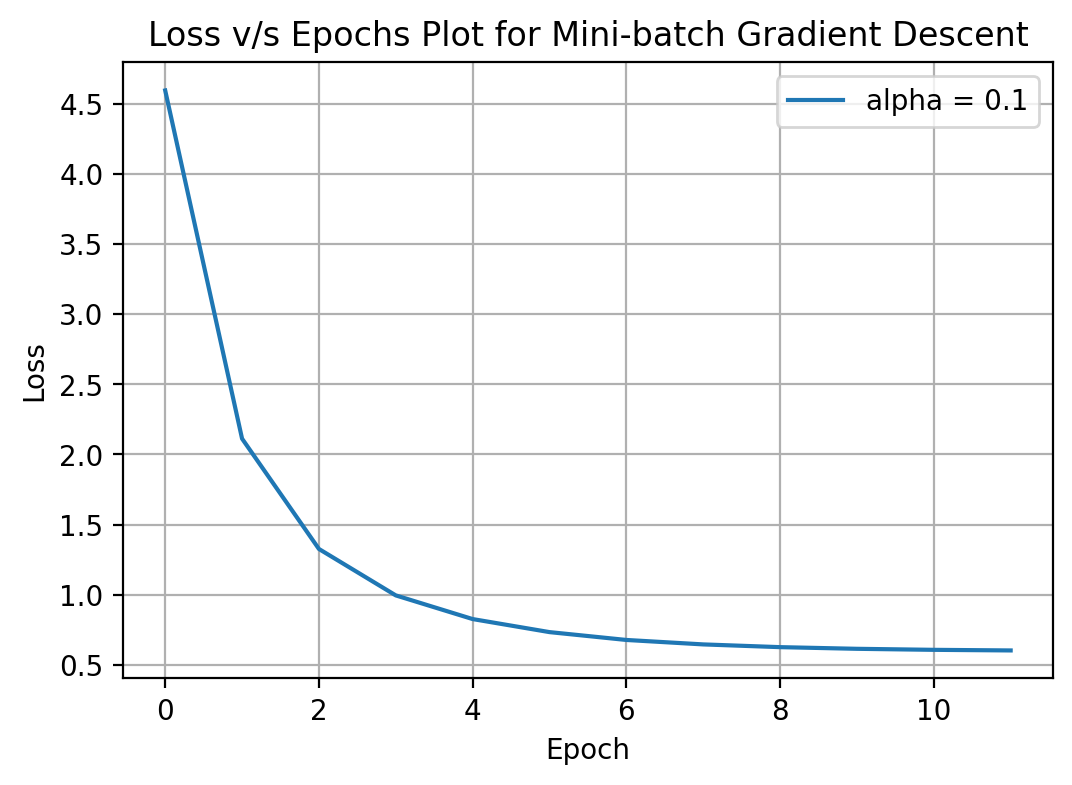

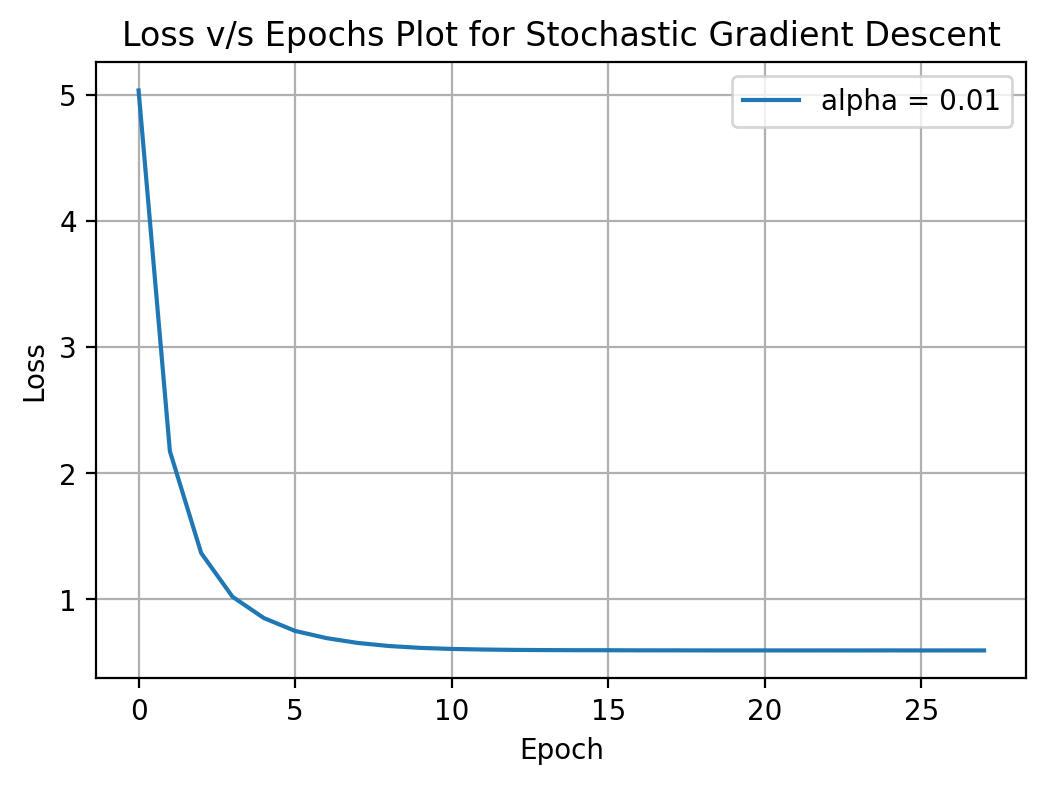

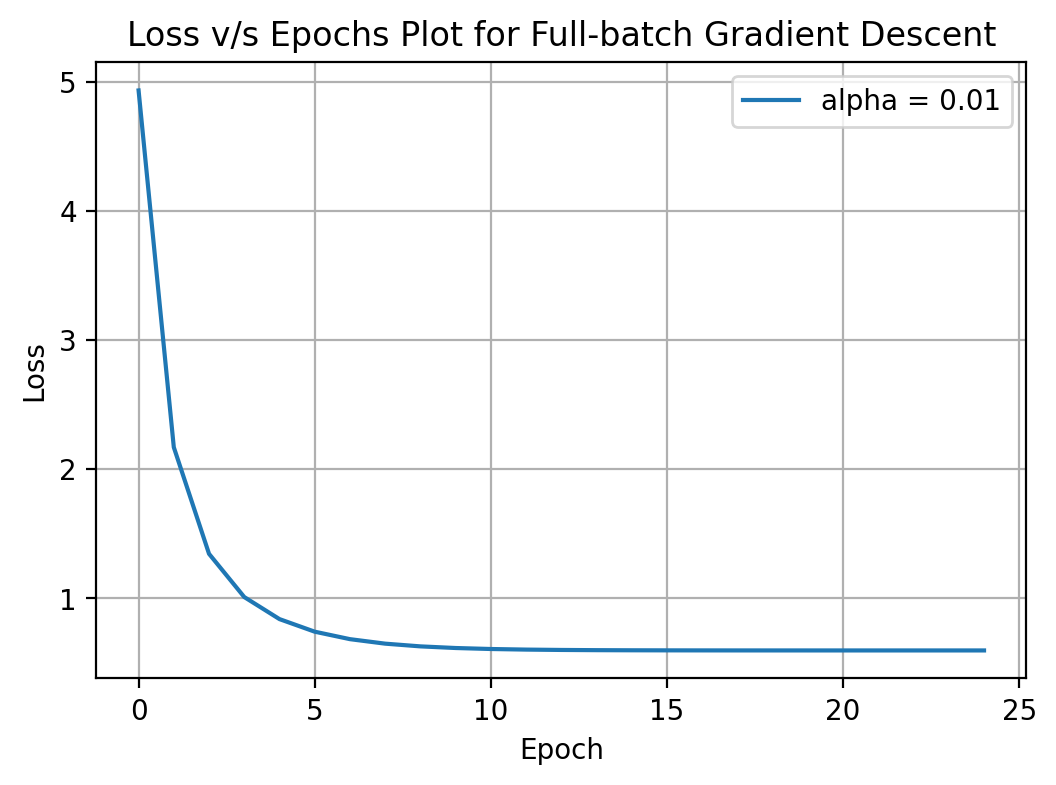

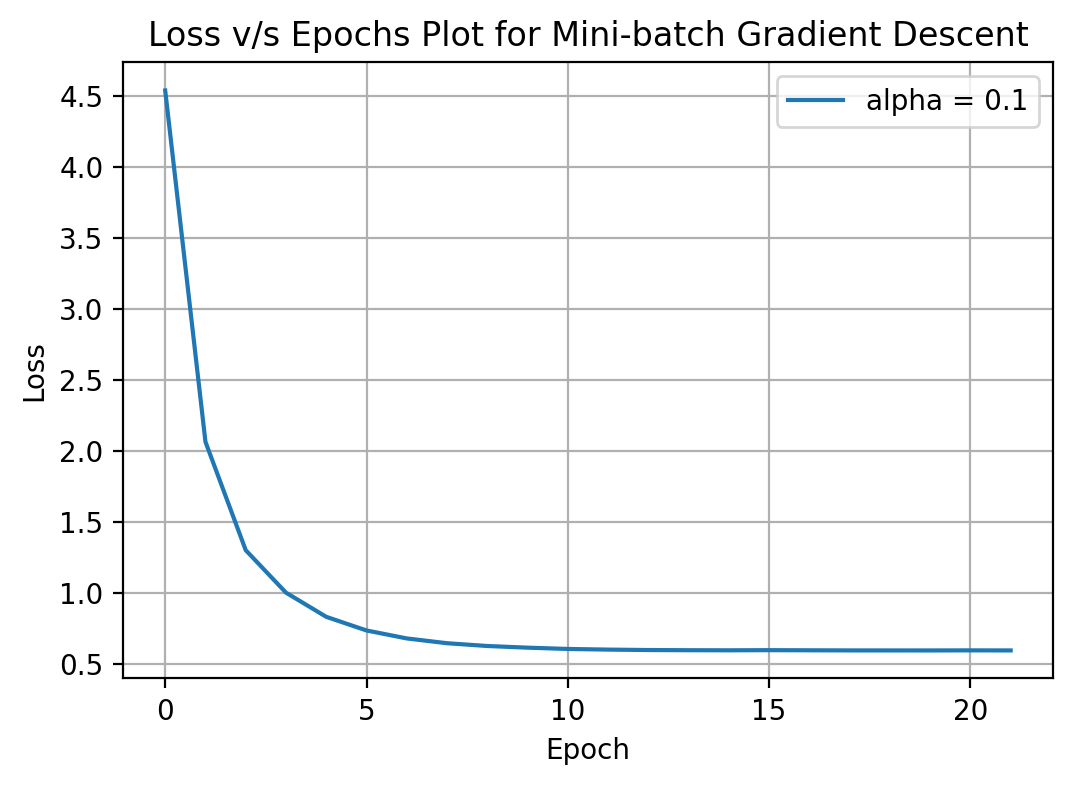

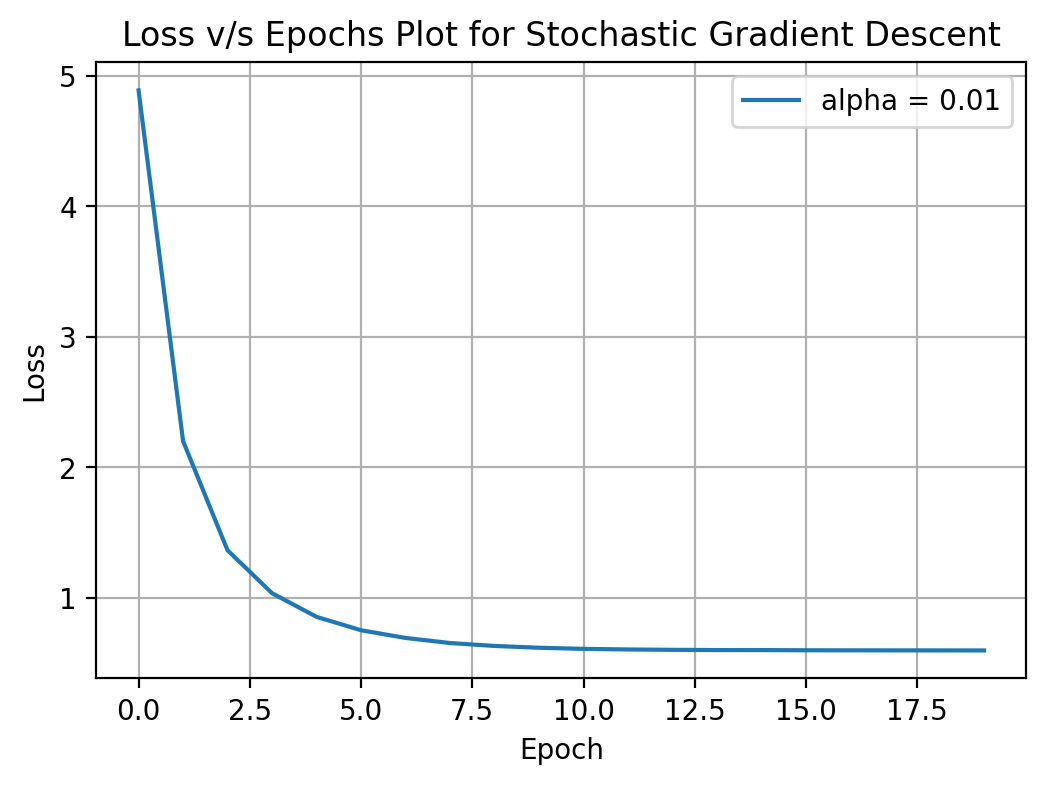

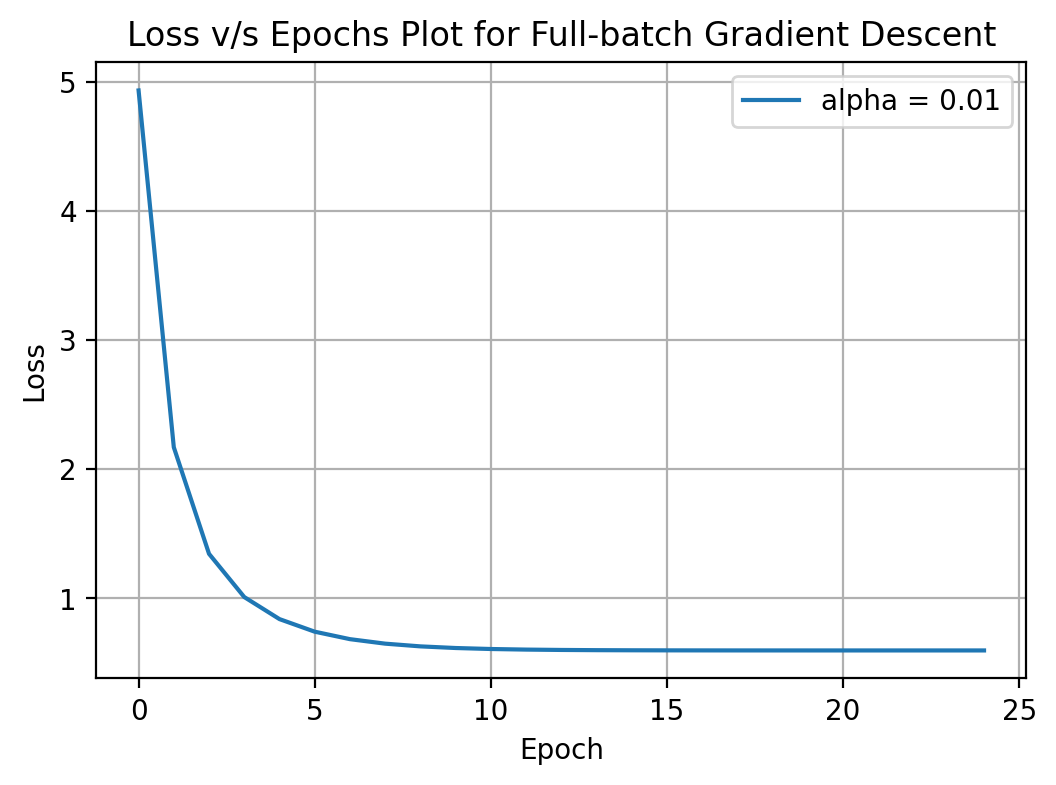

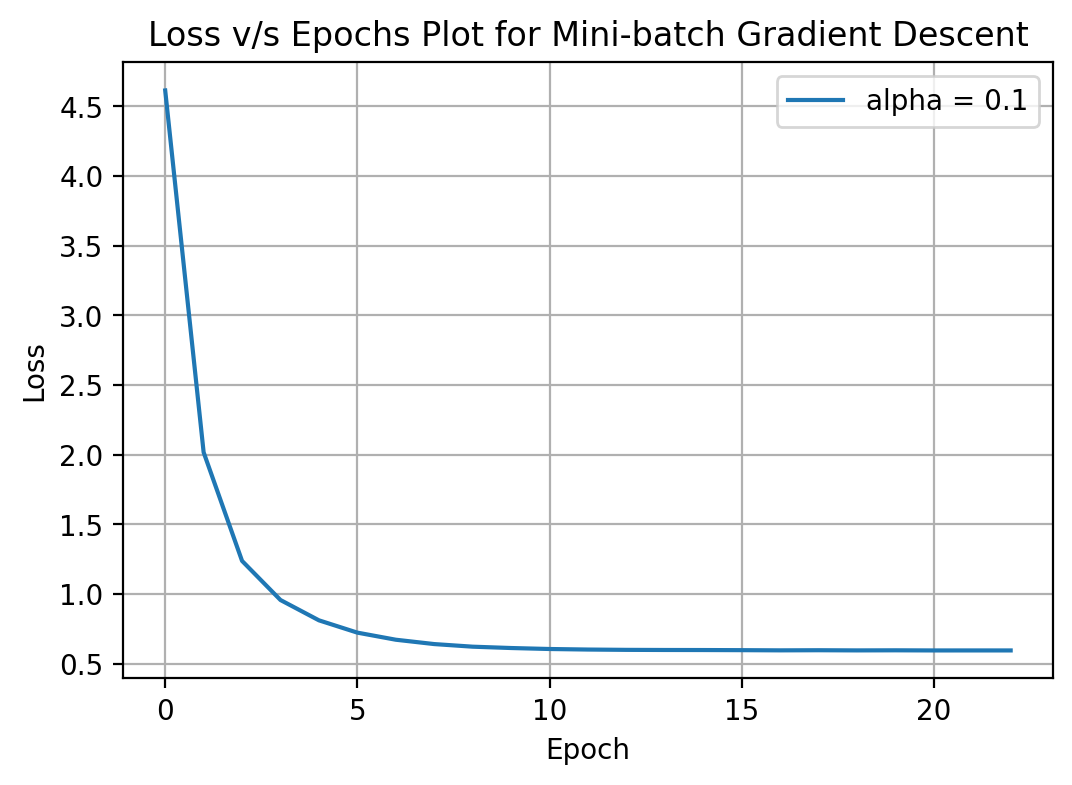

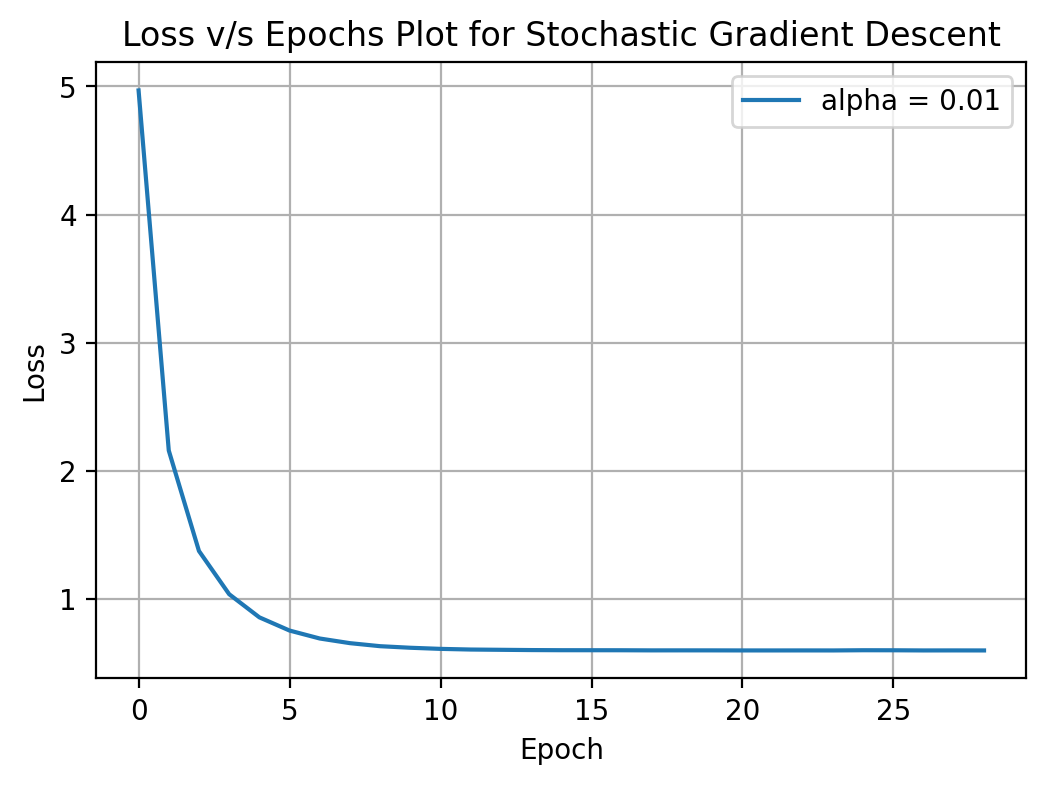

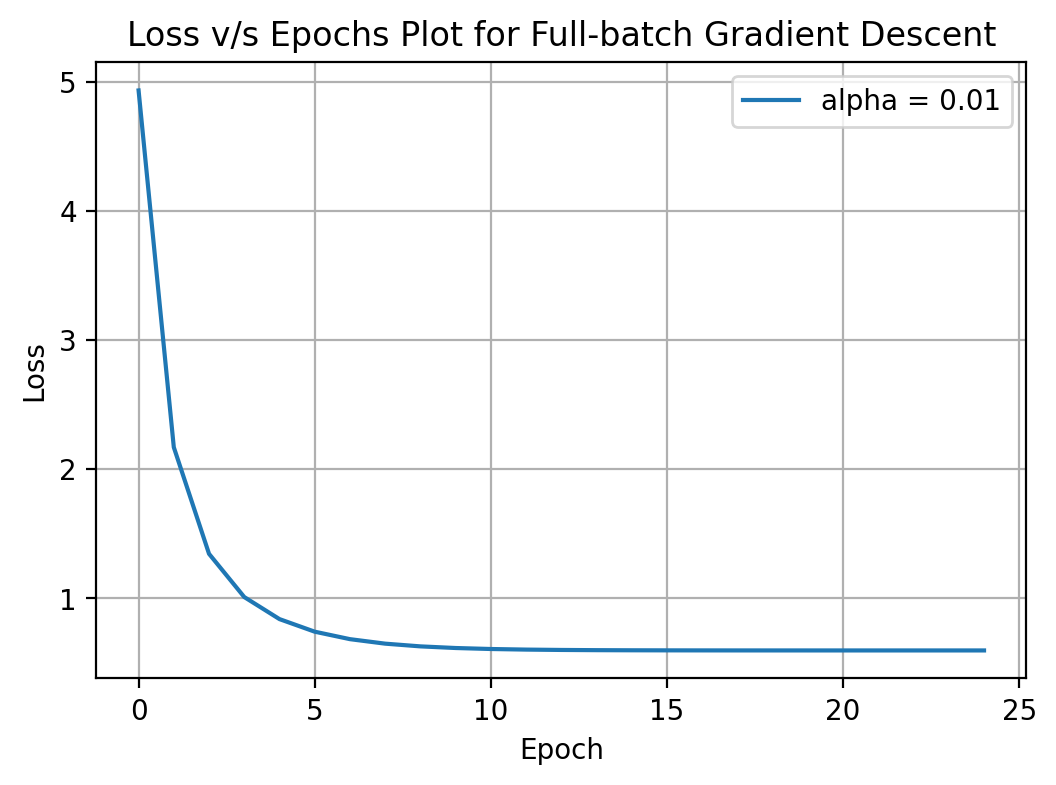

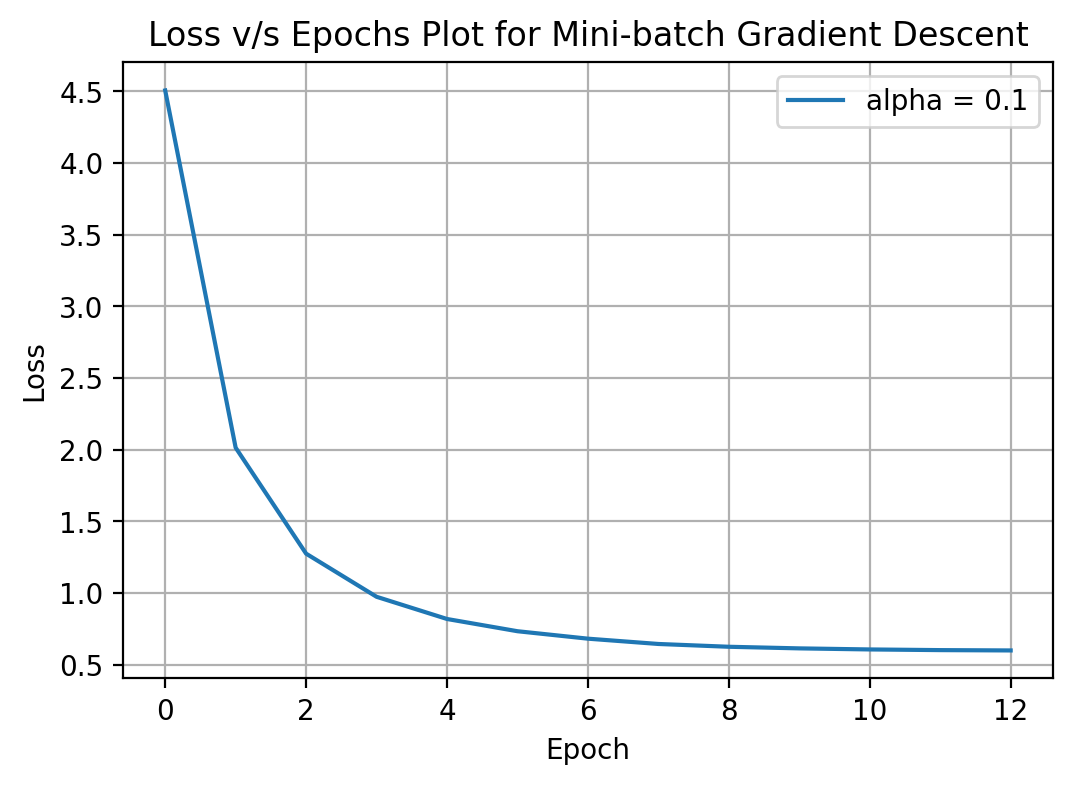

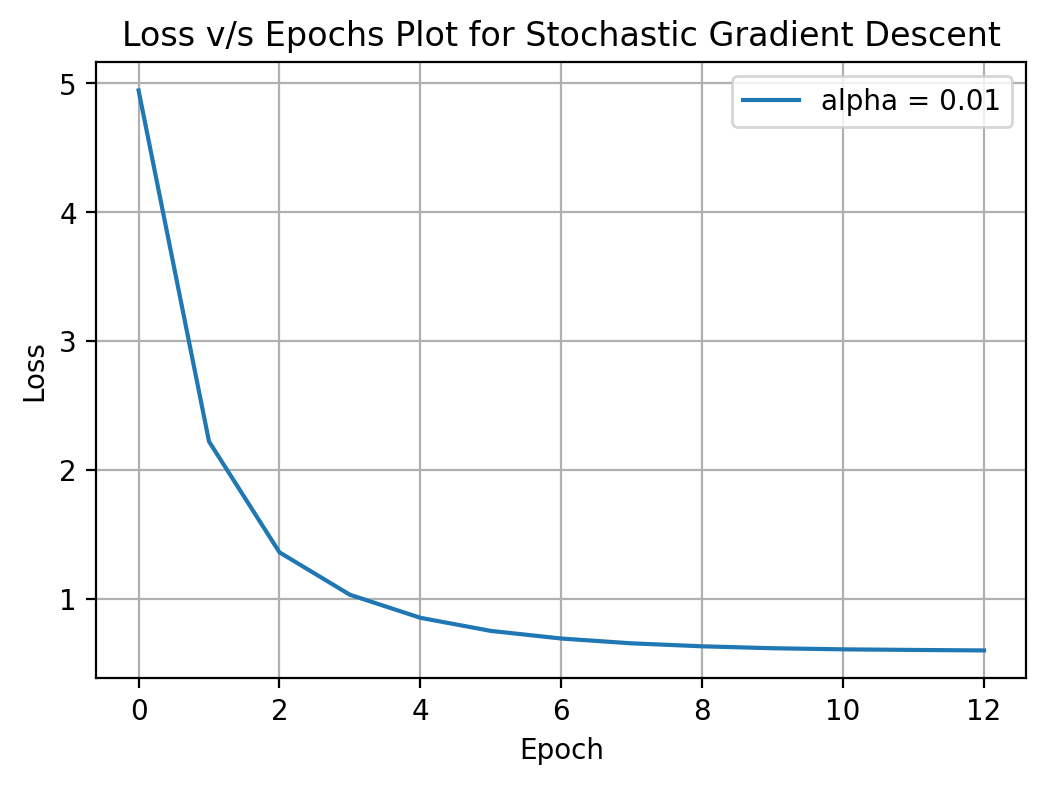

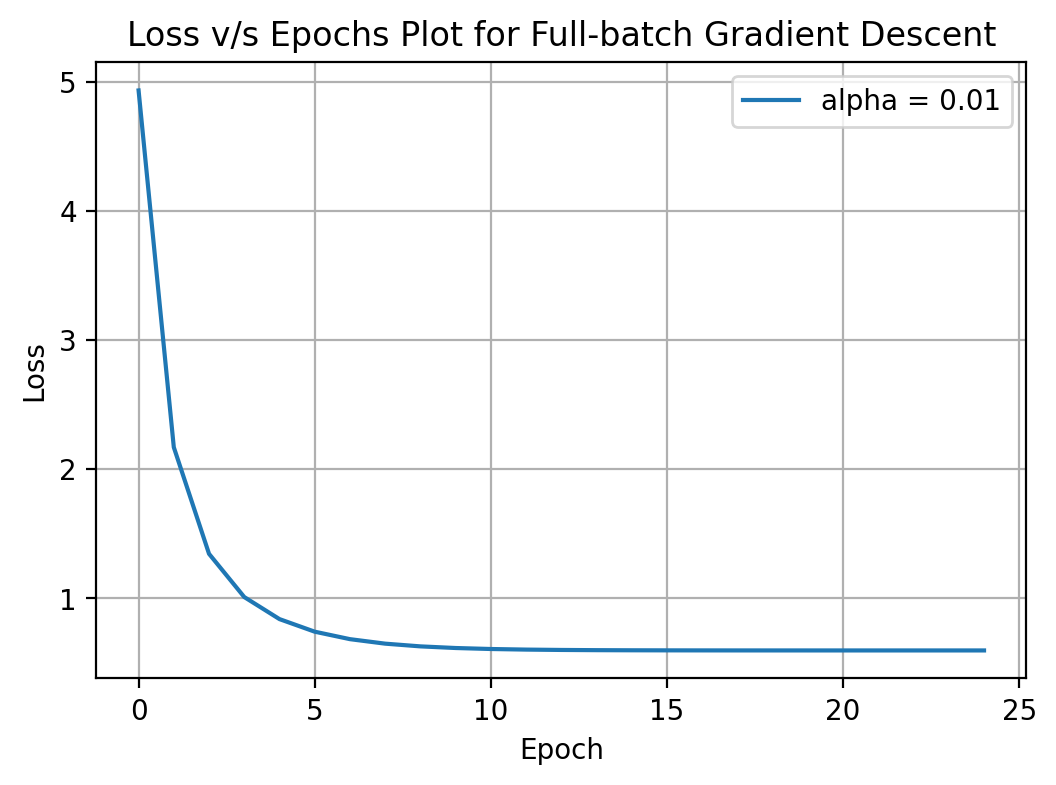

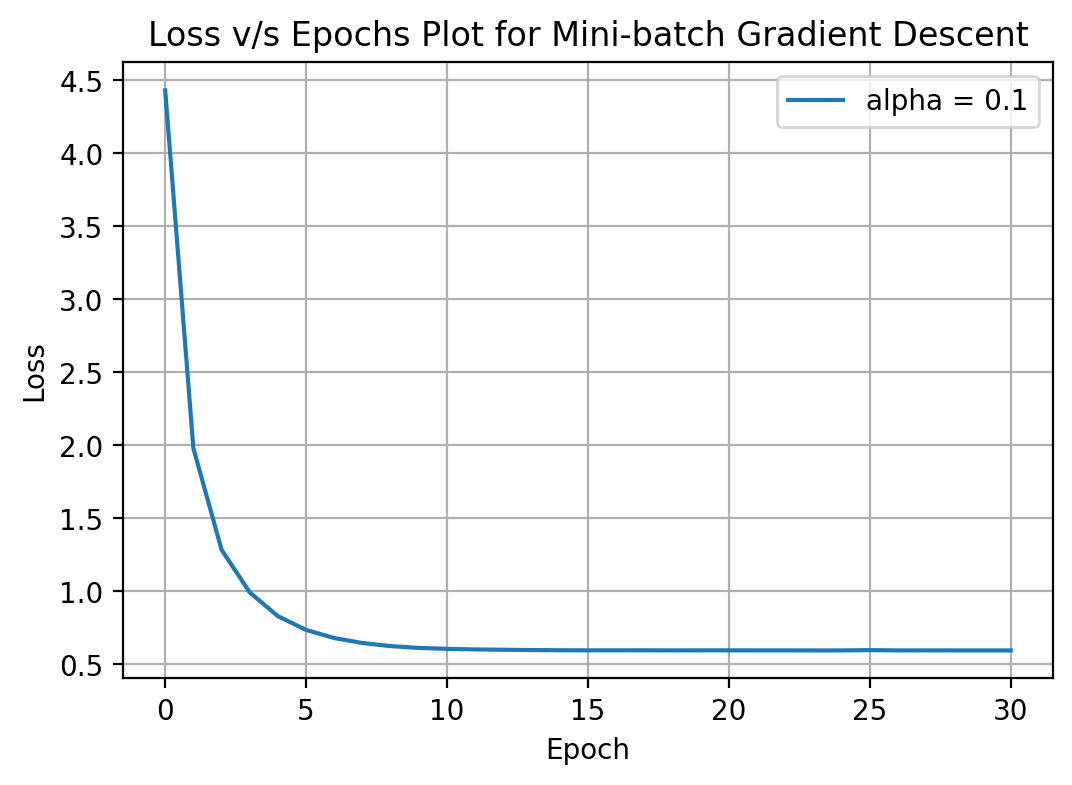

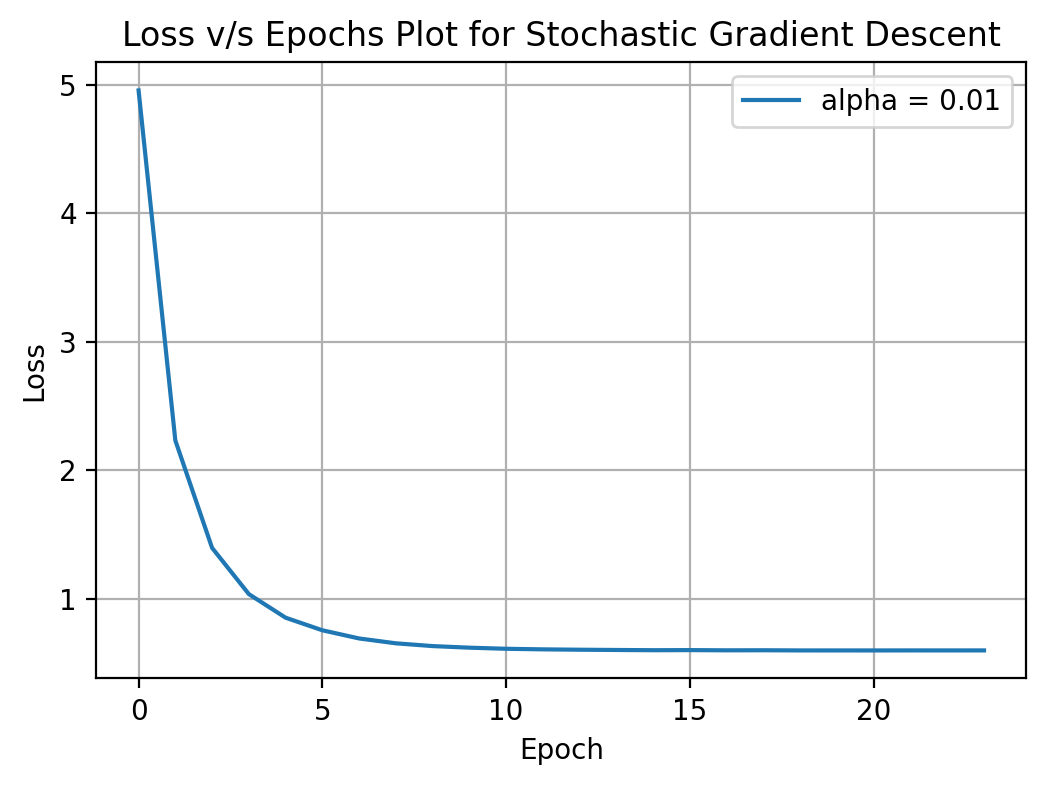

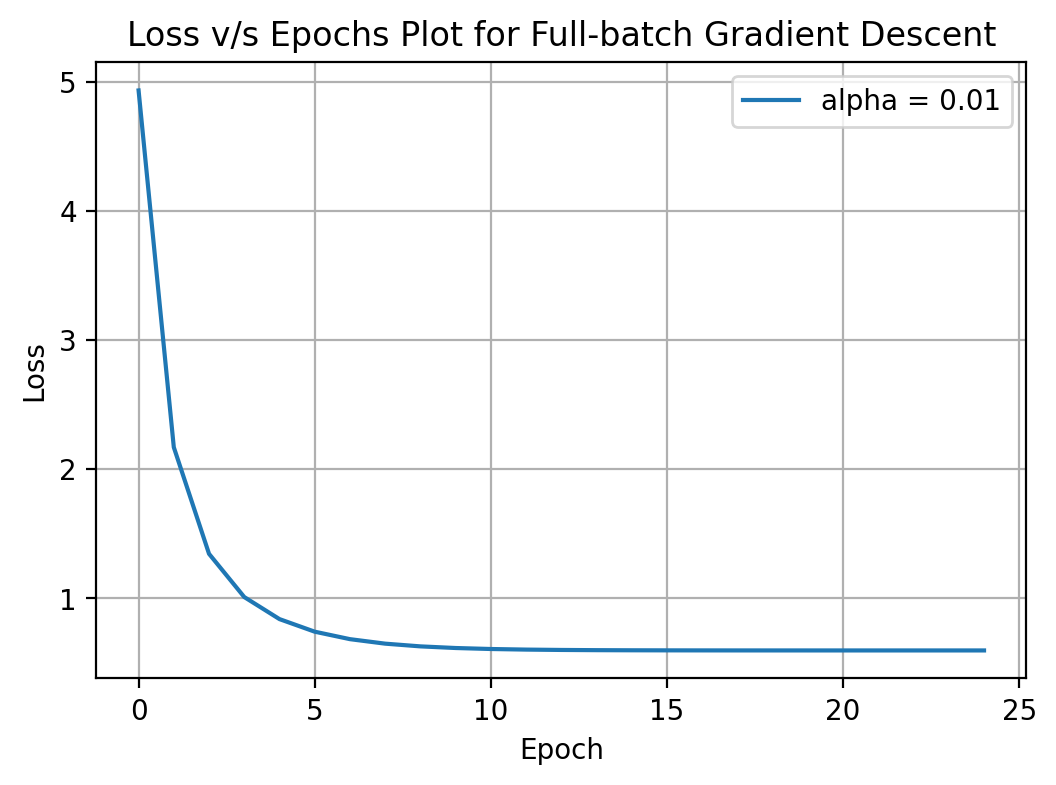

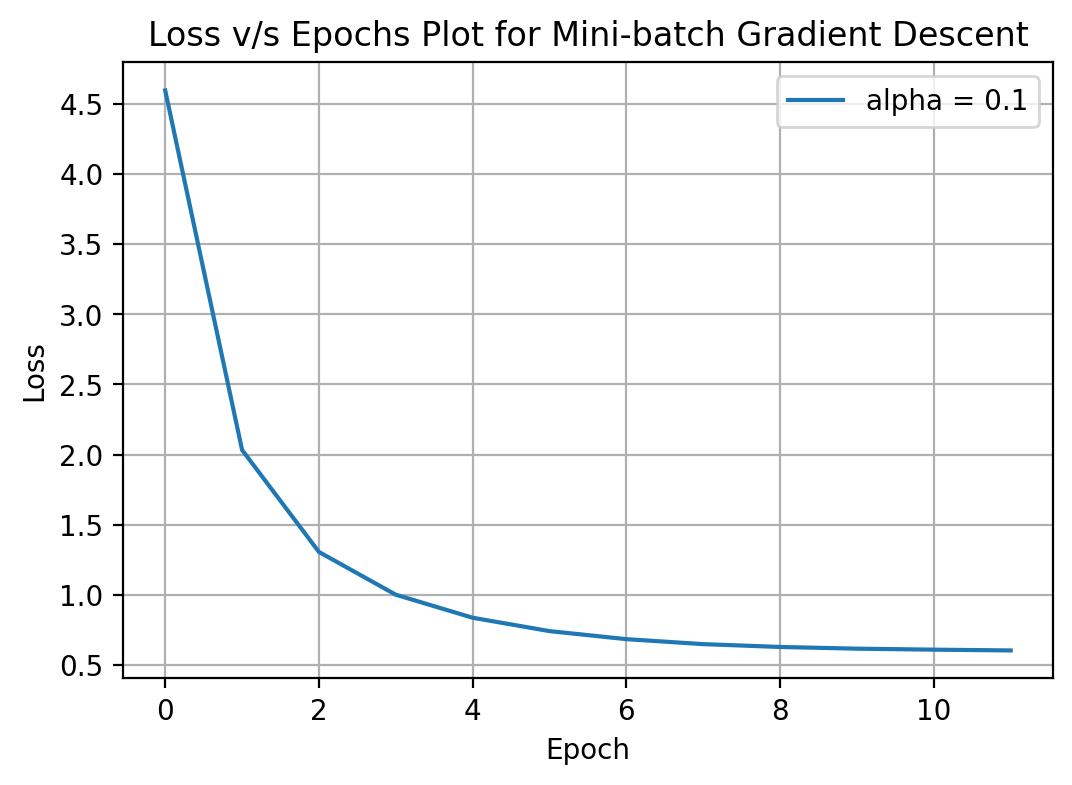

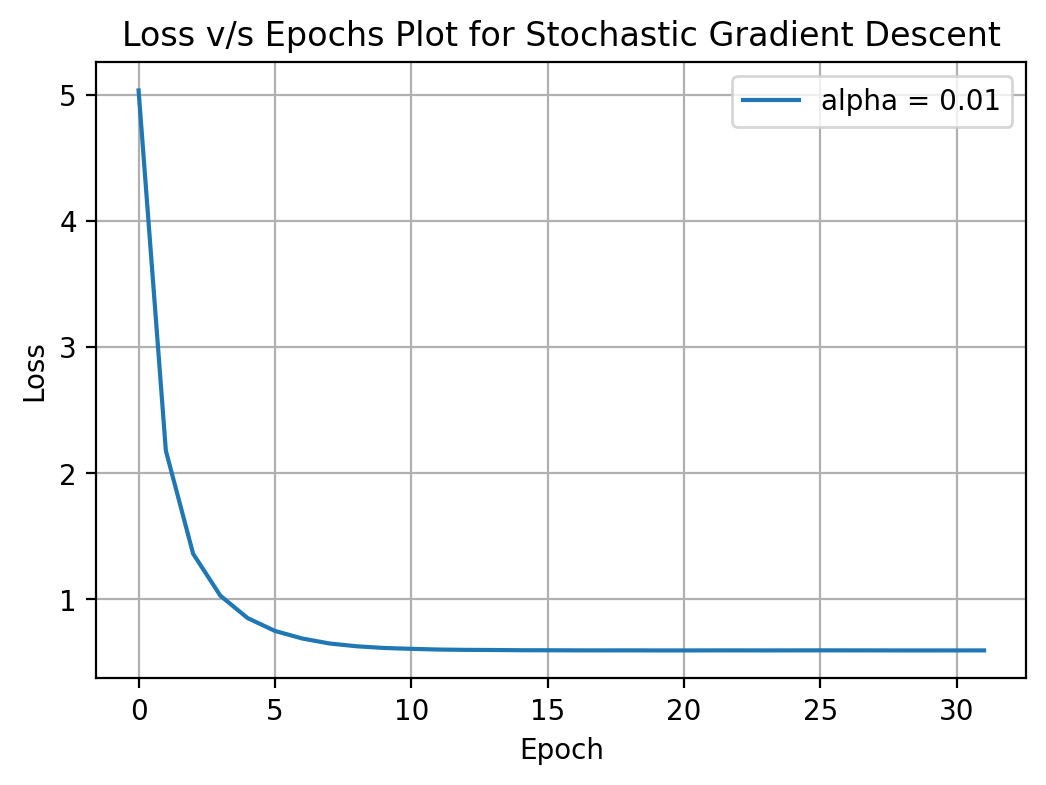

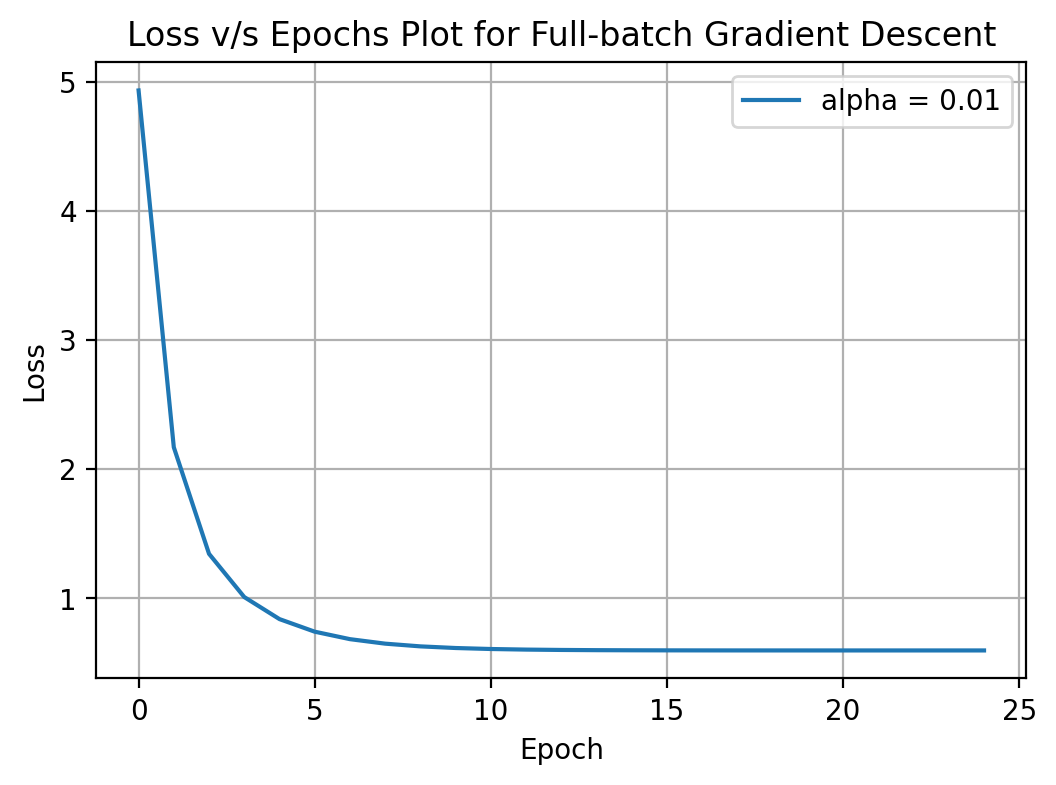

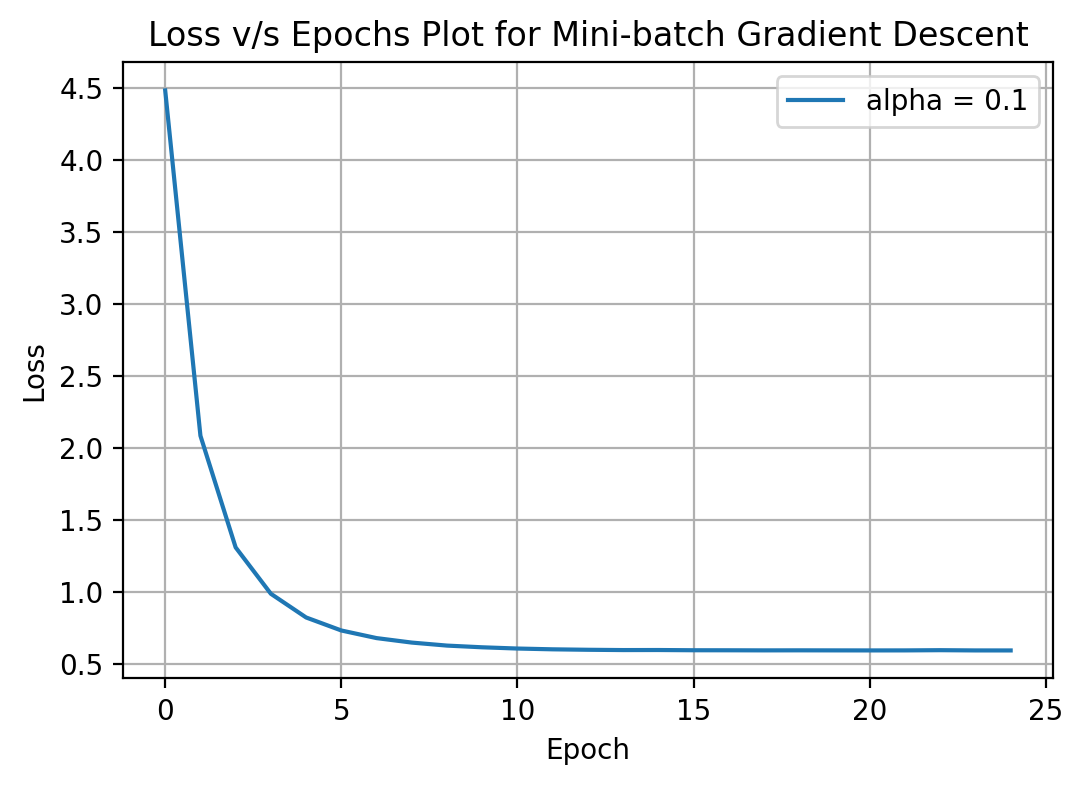

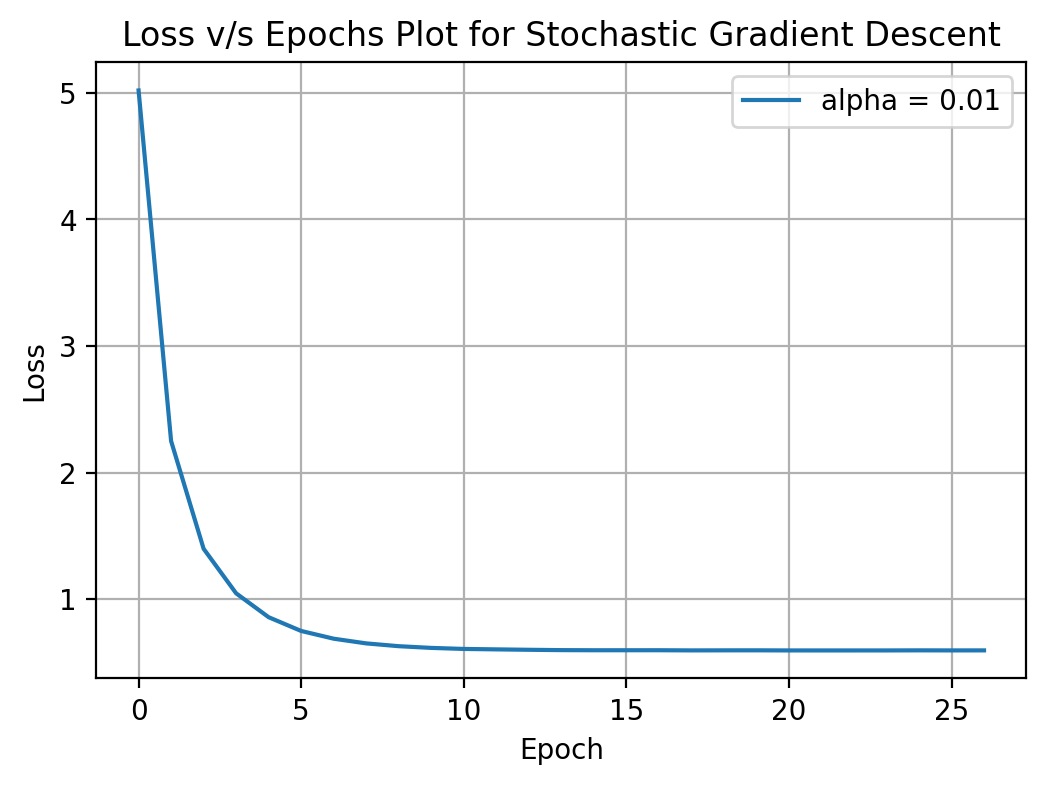

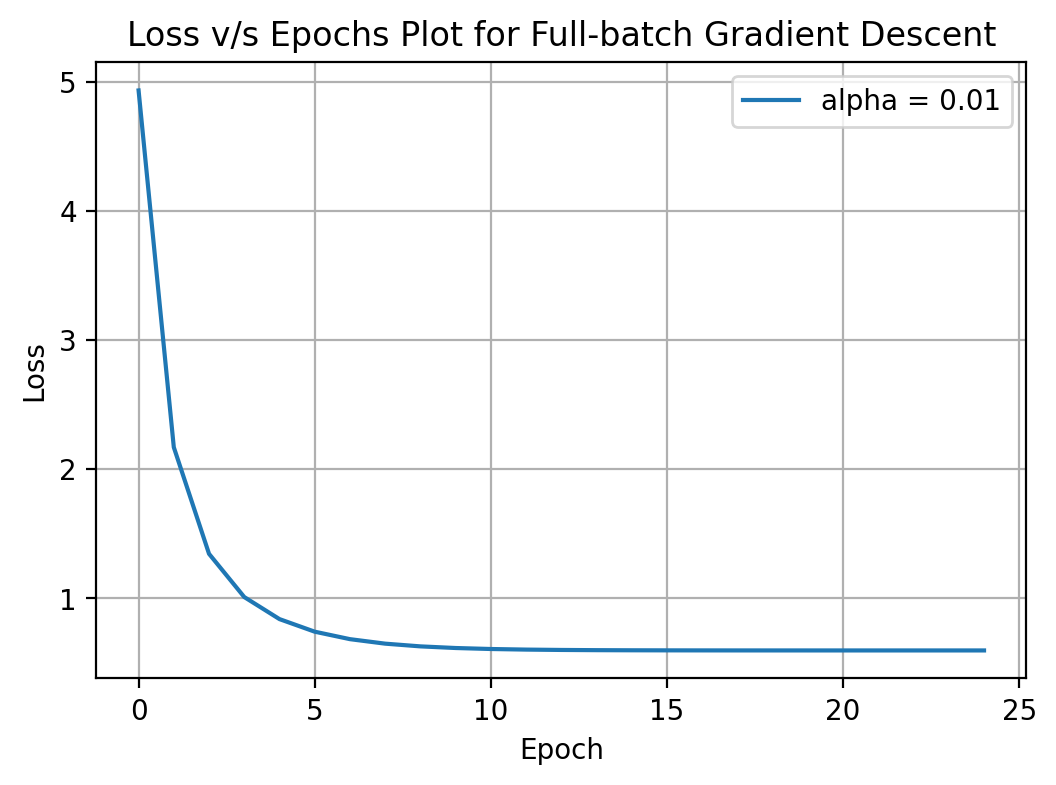

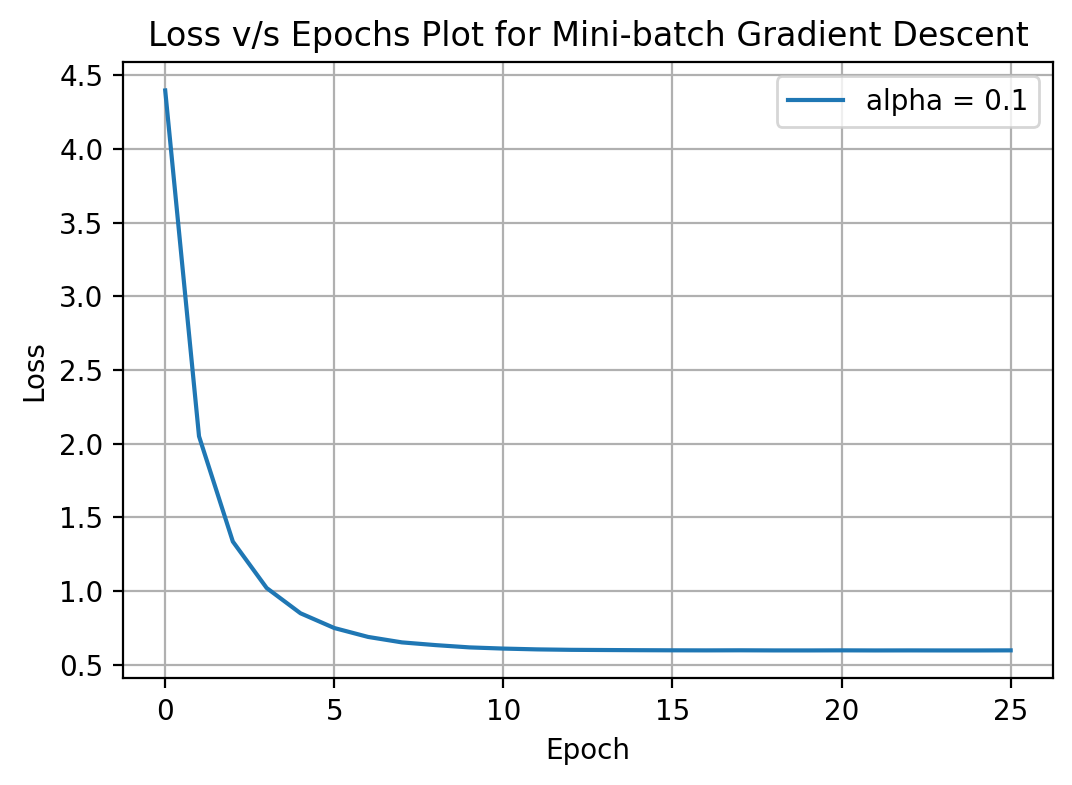

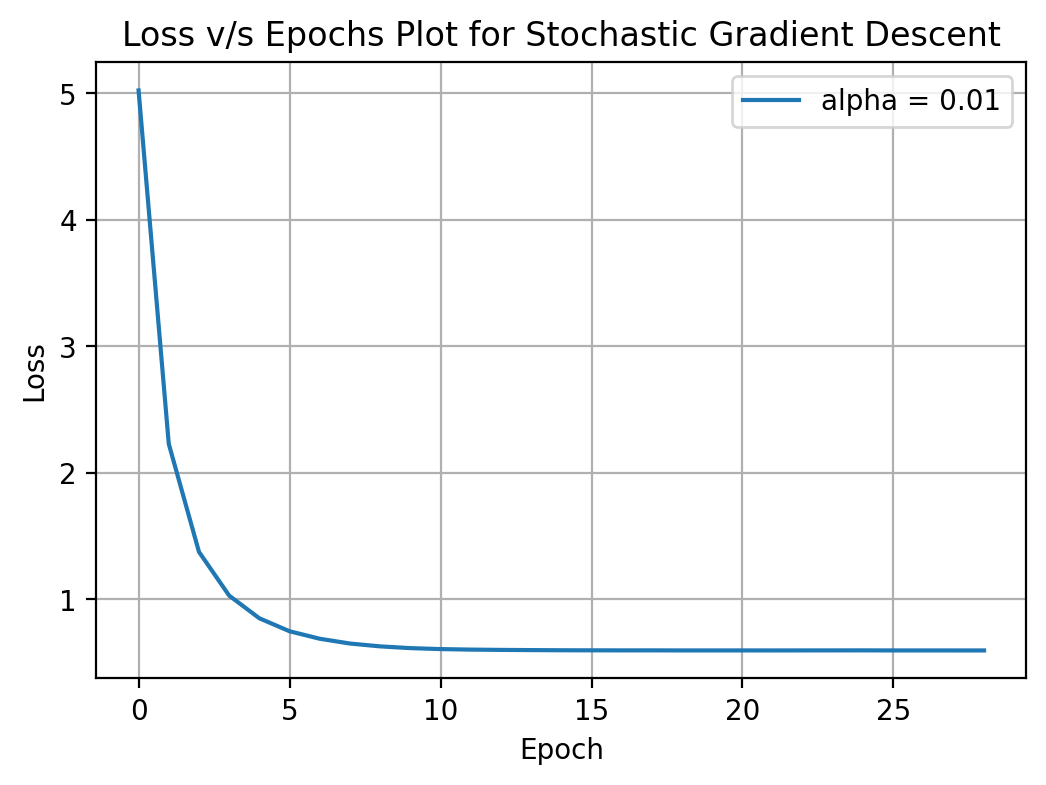

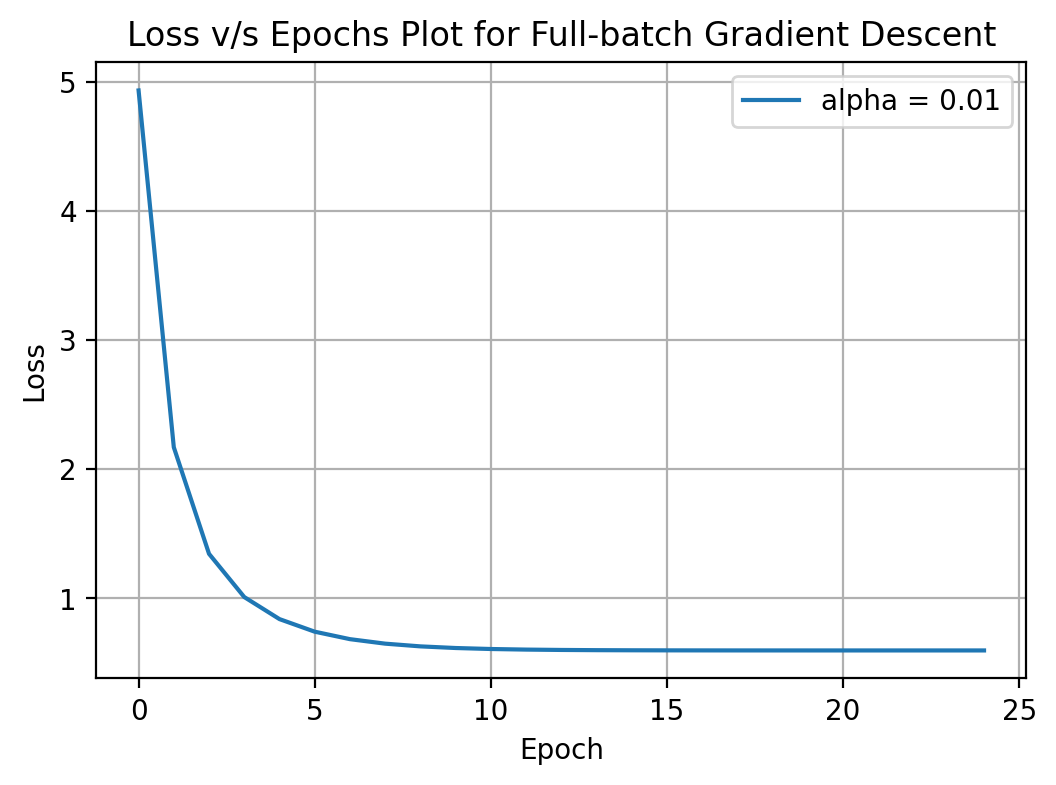

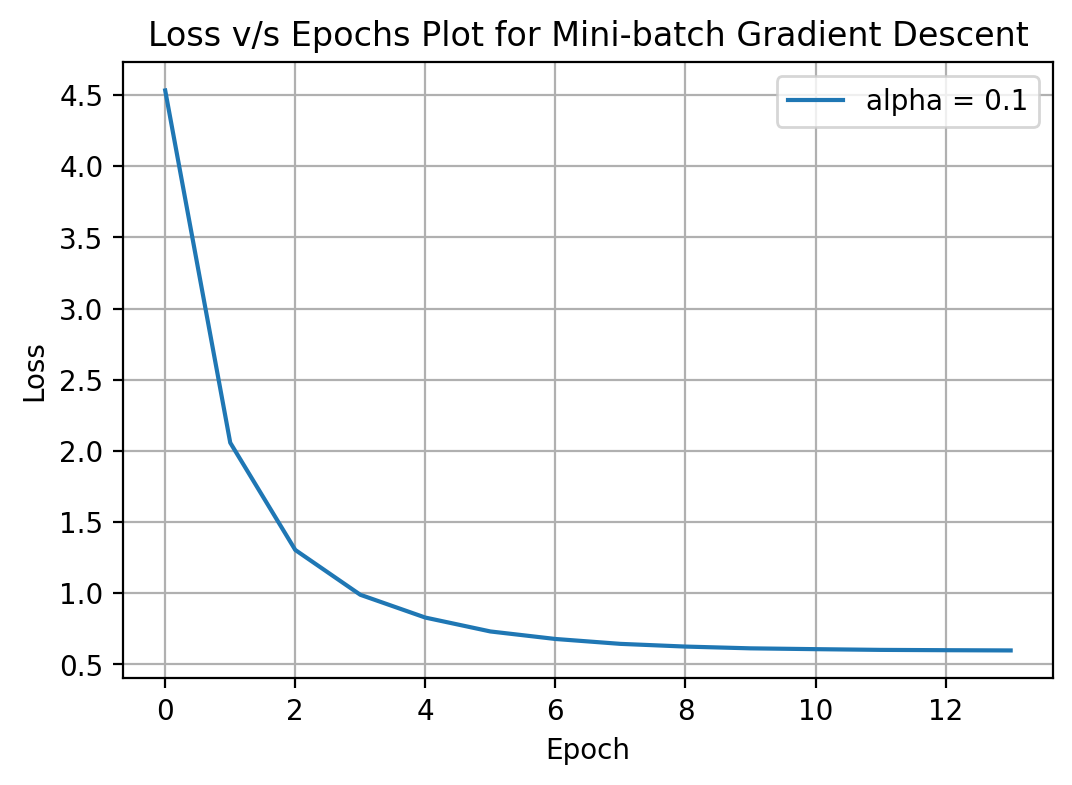

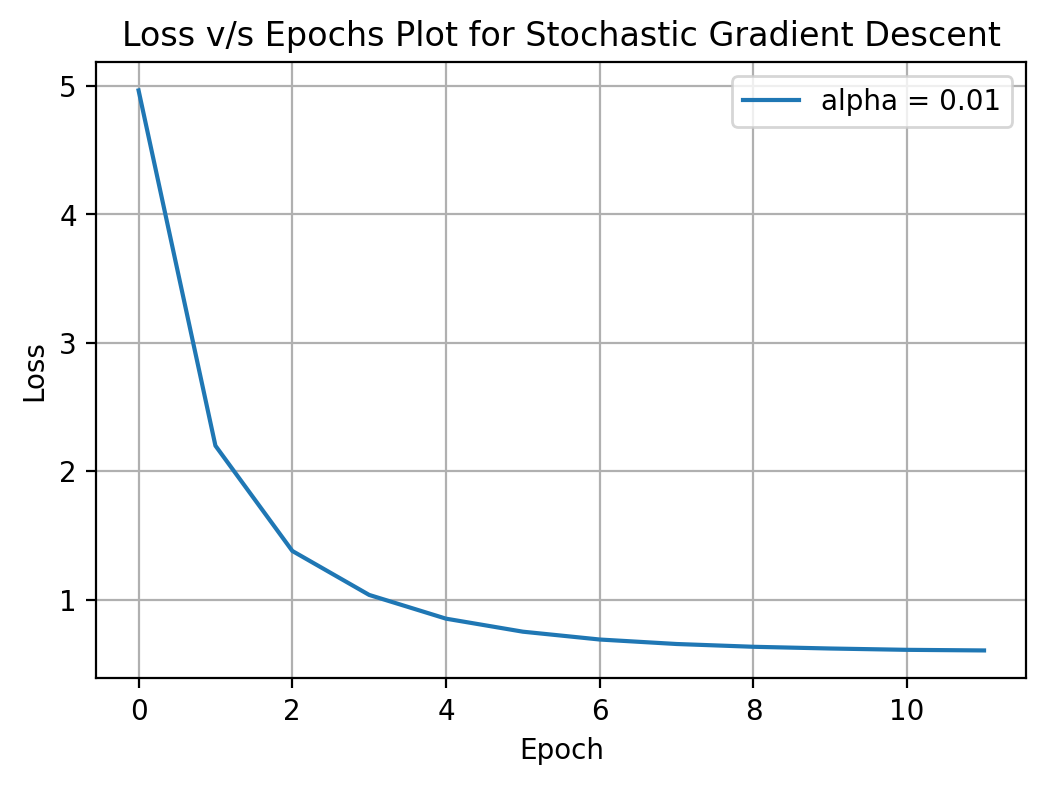

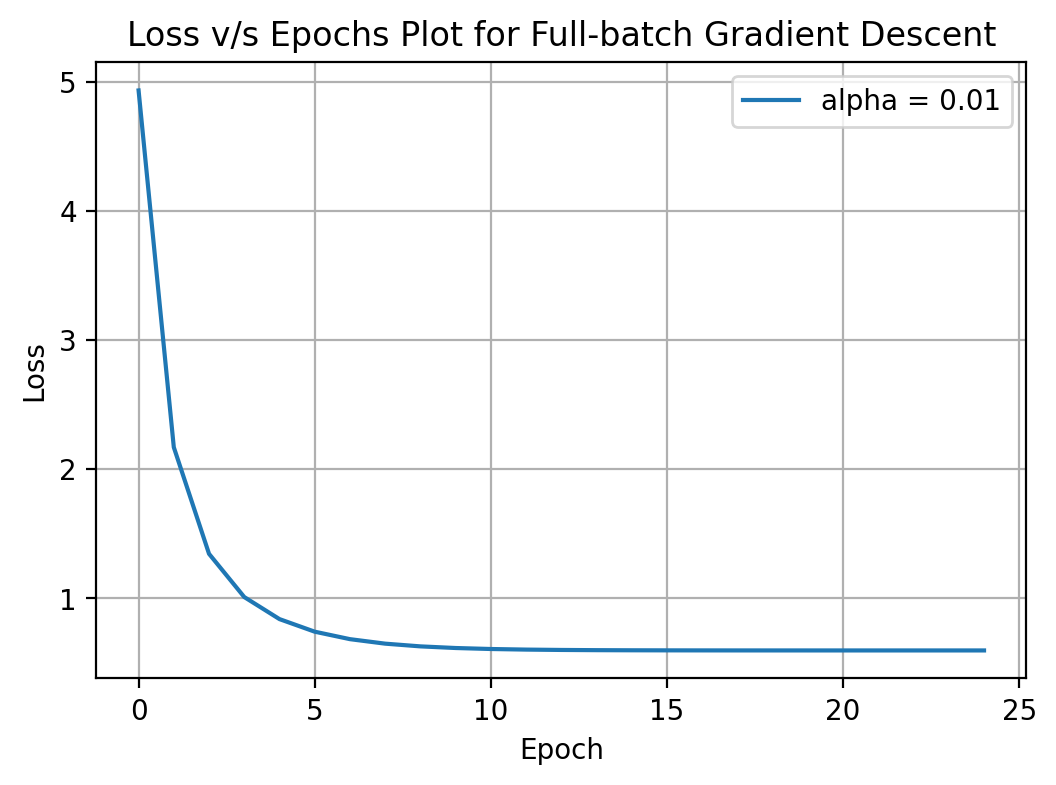

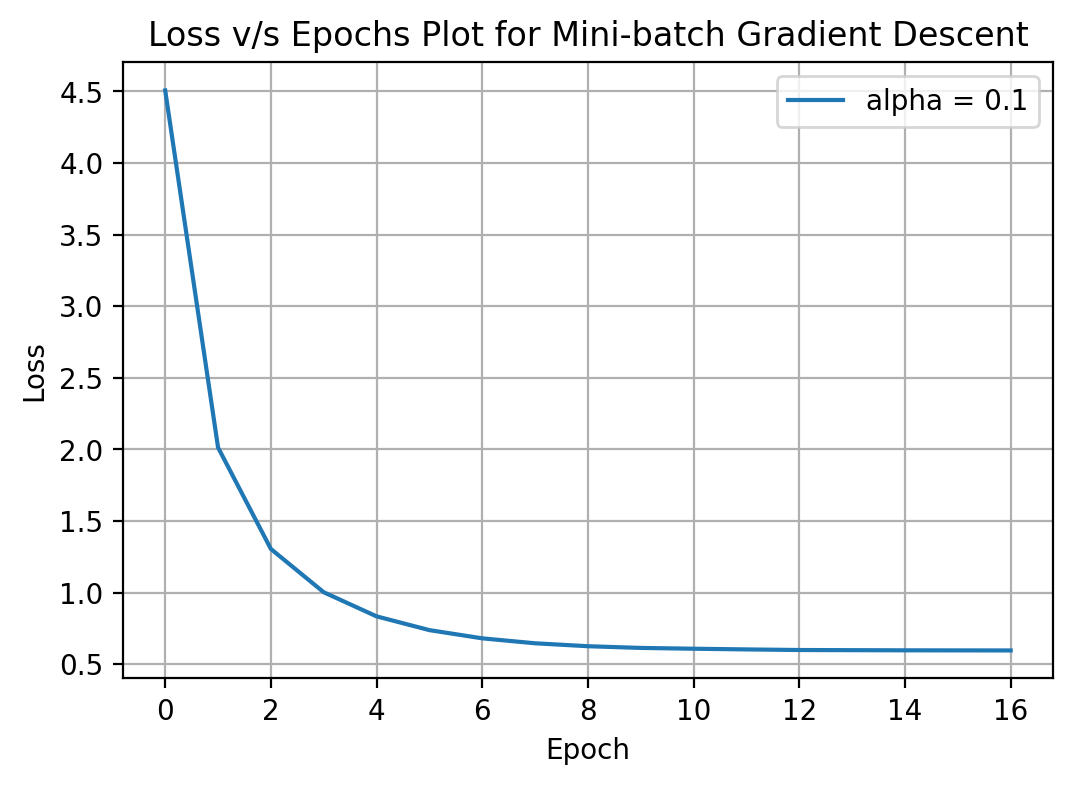

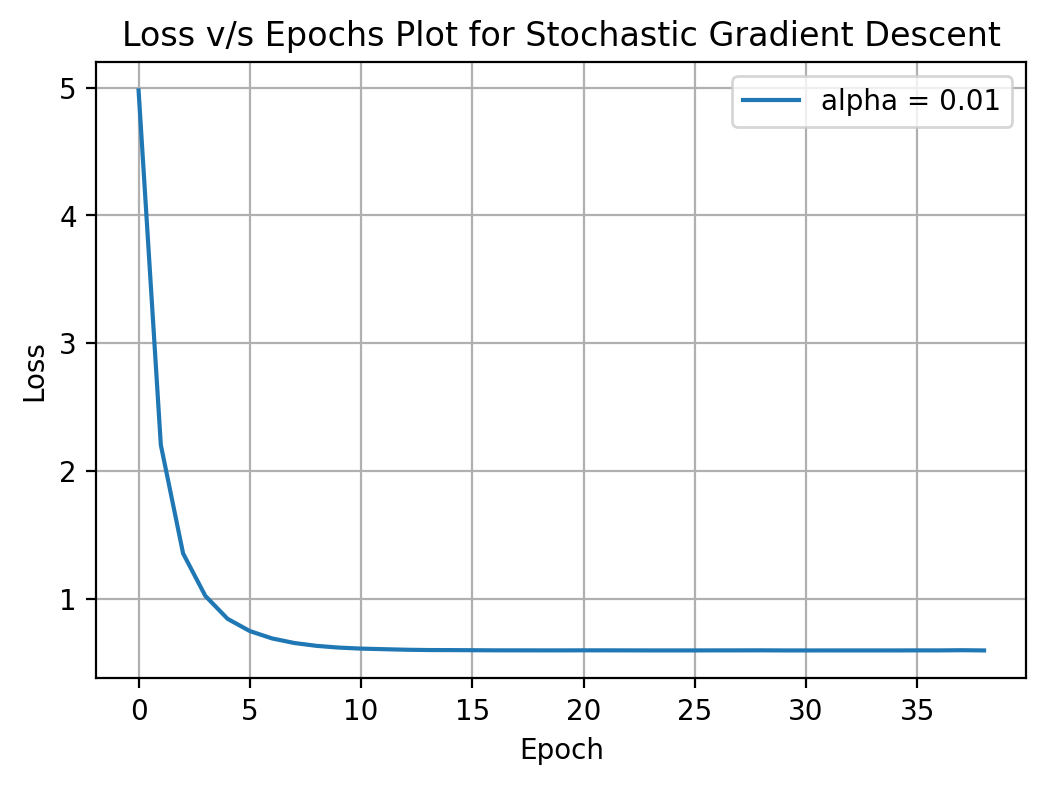

Average number of iteration: 1000.0, epochs: 24.0 for Full Batch Gradient Descent
Average number of iteration: 78.0, epochs: 18.5 for Mini Batch Gradient Descent
Average number of iteration: 1012.0, epochs: 24.3 for Stochastic Gradient Descent


In [83]:
alpha_gd = 0.01
alpha_mbgd = 0.1
alpha_sgd = 0.01
epsilon = 0.001
epochs = 1000
batch_size = 10

def plot_loss_epochs(loss_history, method, alpha):
    plt.figure(figsize=(6, 4))
    plt.plot(loss_history, label=f'alpha = {alpha}')
    plt.title(f'Loss v/s Epochs Plot for {method} Gradient Descent')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def create_XYZ(f):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    X_torch = torch.from_numpy(X)
    Y_torch = torch.from_numpy(Y)
    Z = f(X_torch, Y_torch)
    return X, Y, Z, X_torch, Y_torch

def create_contour(X, Y, Z, ax2, alpha, scatter_pts=None, filled=True, levels=10):
    if filled:
        scatter_color='white'
        contour = ax2.contourf(X, Y, Z.detach().numpy(), levels=levels, cmap='magma', alpha=alpha)
    else:
        scatter_color='black'
        contour = ax2.contour(X, Y, Z.detach().numpy(), levels=levels, cmap='magma', alpha=alpha)
    if scatter_pts is not None:
        ax2.scatter(scatter_pts[0], scatter_pts[1], s=10, c=scatter_color)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Contour Plot')
    
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(contour, cax=cax)
    return ax2, contour

def gd_step(theta0, theta1, grad_theta0, grad_theta1, alpha):
    theta0.data -= alpha * grad_theta0
    theta1.data -= alpha * grad_theta1
    return theta0, theta1

def loss(theta0, theta1, x, y):
    pred = theta0 + theta1 * x
    return torch.mean((pred - y) ** 2)

def loss_surface(theta0_vals, theta1_vals, x, y):
    Z = torch.zeros((len(theta0_vals), len(theta1_vals)))
    for i, theta0 in enumerate(theta0_vals):
        for j, theta1 in enumerate(theta1_vals):
            Z[i, j] = loss(torch.tensor(theta0), torch.tensor(theta1), x, y)
    return Z

def descent_algorithm(x1_torch, y_torch, method, alpha, epsilon, epochs, batch_size=None):
  theta0 = torch.tensor(0.0, requires_grad=True)
  theta1 = torch.tensor(0.0, requires_grad=True)
  iter = 0
  losses = []
  epoch_lst = []
  theta0_path, theta1_path = [], []

  theta0_vals = np.linspace(-10, 10, 100)
  theta1_vals = np.linspace(-10, 10, 100)
  X, Y = np.meshgrid(theta0_vals, theta1_vals)
  Z = loss_surface(theta0_vals, theta1_vals, x1_torch, y_torch)

  for epoch in range(epochs):
    if method=='full-batch':
      for i in range(len(x1_torch)):
        loss_gd = loss(theta0, theta1, x1_torch[i], y_torch[i])
        loss_gd.backward()
        theta0, theta1 = gd_step(theta0, theta1, theta0.grad, theta1.grad, alpha)
        theta0.grad.zero_()
        theta1.grad.zero_()
        iter += 1

    elif method == 'mini-batch':
      shuffle = torch.randperm(len(x1_torch))
      for i in range(0, len(x1_torch), batch_size):
        batch = shuffle[i:i+batch_size]
        x_batch = x1_torch[batch]
        y_batch = y_torch[batch]
        loss_mbgd = loss(theta0, theta1, x_batch, y_batch)
        loss_mbgd.backward()
        theta0, theta1 = gd_step(theta0, theta1, theta0.grad, theta1.grad, alpha)
        theta0.grad.zero_()
        theta1.grad.zero_()
        iter += 1

    elif method == 'stochastic':
      shuffle = torch.randperm(len(x1_torch))
      for i in shuffle:
        loss_sgd = loss(theta0, theta1, x1_torch[i], y_torch[i])
        loss_sgd.backward()
        theta0, theta1 = gd_step(theta0, theta1, theta0.grad, theta1.grad, alpha)
        theta0.grad.zero_()
        theta1.grad.zero_()
        iter += 1

    loss_final = loss(theta0, theta1, x1_torch, y_torch)
    losses.append(loss_final.item())
    epoch_lst.append(epoch)
    theta0_path.append(theta0.item())
    theta1_path.append(theta1.item())
    fig, ax = plt.subplots()
    ax, contour = create_contour(X, Y, Z, ax, 1.0, scatter_pts=(theta0_path[-1], theta1_path[-1]), filled=True, levels=20)
    ax.axhline(y=theta1_path[-1], color='red', linestyle='--', alpha=0.7)
    ax.axvline(x=theta0_path[-1], color='red', linestyle='--', alpha=0.7)
    ax.scatter([3.9507], [2.6825], s=50, c='pink', marker='x', label='Minima')
    ax.legend()
    plt.title(f"{method} - Epoch {epoch}")
    plt.savefig(f"contour_{method}_epoch_{epoch}.png", bbox_inches="tight")
    plt.close()

    if (abs(theta0 - optimal_theta[0])<epsilon or abs(theta1 - optimal_theta[1])<epsilon):
      break
  return losses, theta0, theta1, iter, epoch_lst

it_f = 0
e_f = 0
it_m = 0
e_m = 0
it_s = 0
e_s = 0

for i in range(10):
    losses_full, theta0_full, theta1_full, iter_full, epoch_full = descent_algorithm(x1_torch, y_torch, 'full-batch', alpha_gd, epsilon, epochs)
    losses_mini, theta0_mini, theta1_mini, iter_mini, epoch_mini = descent_algorithm(x1_torch, y_torch, 'mini-batch', alpha_mbgd, epsilon, epochs, batch_size)
    losses_sgd, theta0_sgd, theta1_sgd, iter_sgd, epoch_sgd = descent_algorithm(x1_torch, y_torch, 'stochastic', alpha_sgd, epsilon, epochs)
    plot_loss_epochs(losses_full, 'Full-batch', alpha_gd)
    plot_loss_epochs(losses_mini, 'Mini-batch', alpha_mbgd)
    plot_loss_epochs(losses_sgd, 'Stochastic', alpha_sgd)
    it_f += iter_full
    e_f += epoch_full[-1]
    it_m += iter_mini
    e_m += epoch_mini[-1]
    it_s += iter_sgd
    e_s += epoch_sgd[-1]

it_f /= 10
e_f /= 10
it_m /= 10
e_m /= 10
it_s /= 10
e_s /= 10
print(f"Average number of iteration: {it_f}, epochs: {e_f} for Full Batch Gradient Descent")
print(f"Average number of iteration: {it_m}, epochs: {e_m} for Mini Batch Gradient Descent")
print(f"Average number of iteration: {it_s}, epochs: {e_s} for Stochastic Gradient Descent")

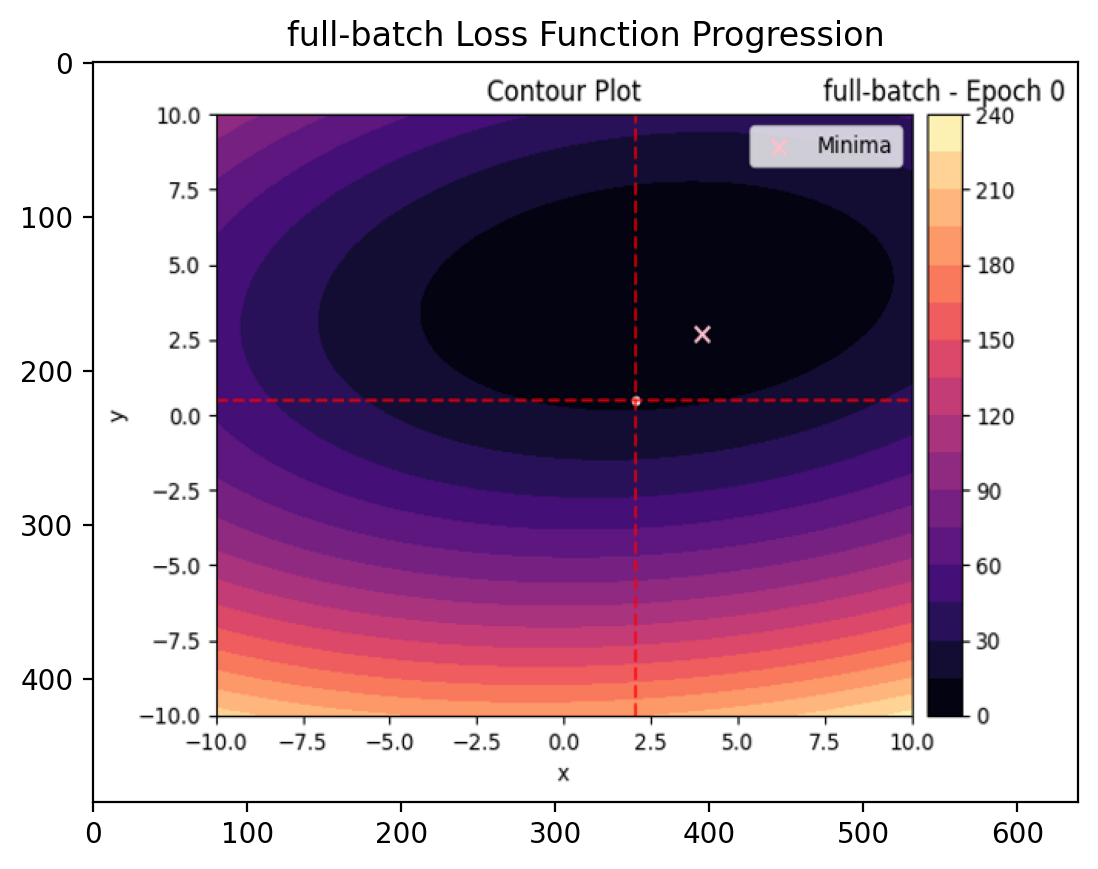

C:\Users\aruls\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


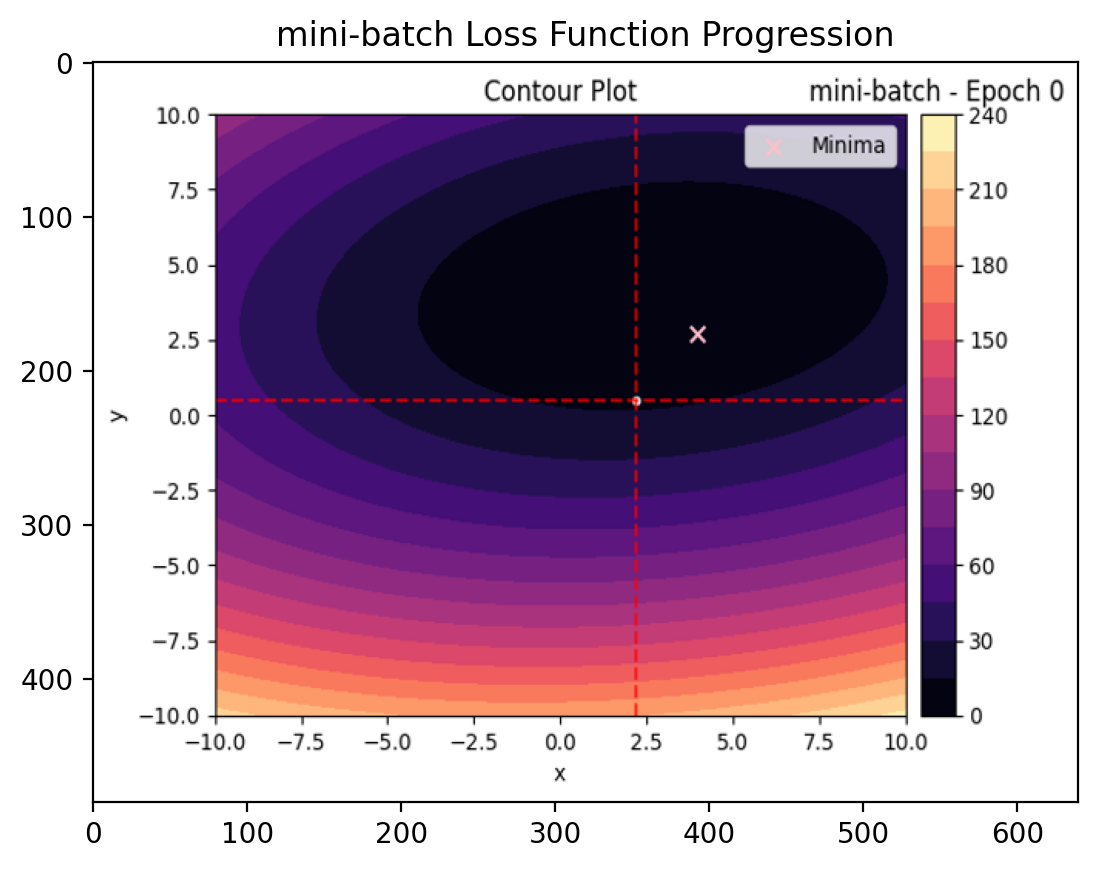

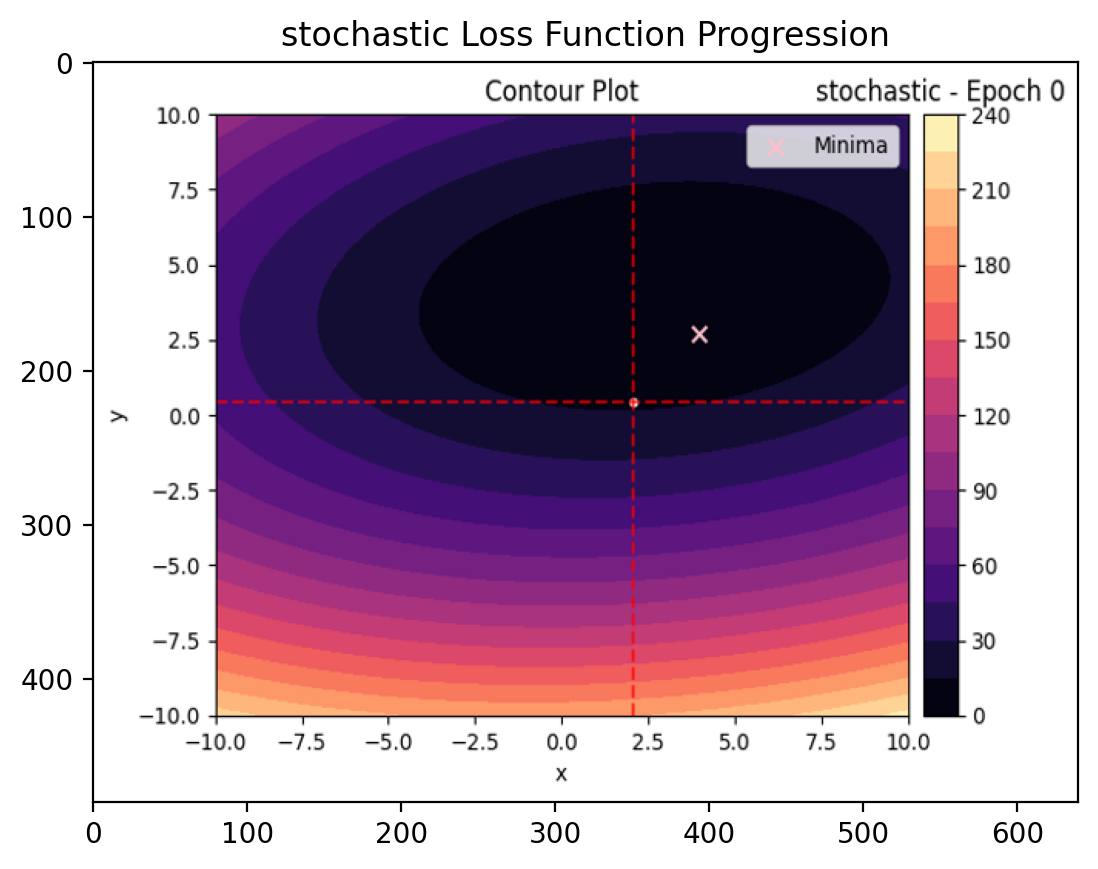

In [84]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import re

def sort_key(filename):
  match = re.search(r"epoch_(\d+)", filename)
  return int(match.group(1)) if match else 0

def create_animation(method_name, file_pattern):
  files = sorted(glob.glob(file_pattern), key=sort_key)
  images = []

  for filename in files:
    image = Image.open(filename)
    image = image.resize((640, 480))  # Consistent resize for all images
    images.append(np.array(image))

  fig, ax = plt.subplots()
  im = ax.imshow(images[0], animated=True)
  ax.set_title(f"{method_name} Loss Function Progression")

  def update(frame):
    im.set_array(images[frame])
    return im,

  animation_fig = animation.FuncAnimation(fig, update, frames=len(images))
  plt.show()

methods = ["full-batch", "mini-batch", "stochastic"]
for method in methods:
  file_pattern = f"contour_{method}_epoch_*.png"
  create_animation(method, file_pattern)

# Gradient Descent with Momentum

In [87]:
alpha_gd = 0.01
alpha_mbgd = 0.1
alpha_sgd = 0.01
beta = 0.9
epsilon = 0.001
epochs = 1000
batch_size = 10

def plot_loss_epochs(loss_history, method, alpha):
    plt.figure(figsize=(6, 4))
    plt.plot(loss_history, label=f'alpha = {alpha}')
    plt.title(f'Loss v/s Epochs Plot for {method} Gradient Descent')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def create_XYZ(f):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    X_torch = torch.from_numpy(X)
    Y_torch = torch.from_numpy(Y)
    Z = f(X_torch, Y_torch)
    return X, Y, Z, X_torch, Y_torch

def create_contour(X, Y, Z, ax2, alpha, scatter_pts=None, filled=True, levels=10):
    if filled:
        scatter_color='white'
        contour = ax2.contourf(X, Y, Z.detach().numpy(), levels=levels, cmap='magma', alpha=alpha)
    else:
        scatter_color='black'
        contour = ax2.contour(X, Y, Z.detach().numpy(), levels=levels, cmap='magma', alpha=alpha)
    if scatter_pts is not None:
        ax2.scatter(scatter_pts[0], scatter_pts[1], s=10, c=scatter_color)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Contour Plot')
    
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(contour, cax=cax)
    return ax2, contour

def gd_step(theta0, theta1, grad_theta0, grad_theta1, alpha, beta):
    vel_theta0 = beta * vel_theta0 + (1 - beta) * theta0.grad
    vel_theta1 = beta * vel_theta1 + (1 - beta) * theta1.grad
    theta0.data -= alpha * vel_theta0
    theta1.data -= alpha * vel_theta1
    return theta0, theta1

def loss(theta0, theta1, x, y):
    pred = theta0 + theta1 * x
    return torch.mean((pred - y) ** 2)

def loss_surface(theta0_vals, theta1_vals, x, y):
    Z = torch.zeros((len(theta0_vals), len(theta1_vals)))
    for i, theta0 in enumerate(theta0_vals):
        for j, theta1 in enumerate(theta1_vals):
            Z[i, j] = loss(torch.tensor(theta0), torch.tensor(theta1), x, y)
    return Z

def descent_algorithm(x1_torch, y_torch, method, alpha, epsilon, epochs, beta, batch_size=None):
  theta0 = torch.tensor(0.0, requires_grad=True)
  theta1 = torch.tensor(0.0, requires_grad=True)
  iter = 0
  losses = []
  epoch_lst = []
  theta0_path, theta1_path = [], []

  theta0_vals = np.linspace(-10, 10, 100)
  theta1_vals = np.linspace(-10, 10, 100)
  X, Y = np.meshgrid(theta0_vals, theta1_vals)
  Z = loss_surface(theta0_vals, theta1_vals, x1_torch, y_torch)

  for epoch in range(epochs):
    if method=='full-batch':
      for i in range(len(x1_torch)):
        loss_gd = loss(theta0, theta1, x1_torch[i], y_torch[i])
        loss_gd.backward()
        theta0, theta1 = gd_step(theta0, theta1, theta0.grad, theta1.grad, alpha, beta)
        theta0.grad.zero_()
        theta1.grad.zero_()
        iter += 1

    elif method == 'mini-batch':
      shuffle = torch.randperm(len(x1_torch))
      for i in range(0, len(x1_torch), batch_size):
        batch = shuffle[i:i+batch_size]
        x_batch = x1_torch[batch]
        y_batch = y_torch[batch]
        loss_mbgd = loss(theta0, theta1, x_batch, y_batch)
        loss_mbgd.backward()
        theta0, theta1 = gd_step(theta0, theta1, theta0.grad, theta1.grad, alpha, beta)
        theta0.grad.zero_()
        theta1.grad.zero_()
        iter += 1

    elif method == 'stochastic':
      shuffle = torch.randperm(len(x1_torch))
      for i in shuffle:
        loss_sgd = loss(theta0, theta1, x1_torch[i], y_torch[i])
        loss_sgd.backward()
        theta0, theta1 = gd_step(theta0, theta1, theta0.grad, theta1.grad, alpha, beta)
        theta0.grad.zero_()
        theta1.grad.zero_()
        iter += 1

    loss_final = loss(theta0, theta1, x1_torch, y_torch)
    losses.append(loss_final.item())
    epoch_lst.append(epoch)
    theta0_path.append(theta0.item())
    theta1_path.append(theta1.item())
    # fig, ax = plt.subplots()
    # ax, contour = create_contour(X, Y, Z, ax, 1.0, scatter_pts=(theta0_path[-1], theta1_path[-1]), filled=True, levels=20)
    # ax.axhline(y=theta1_path[-1], color='red', linestyle='--', alpha=0.7)
    # ax.axvline(x=theta0_path[-1], color='red', linestyle='--', alpha=0.7)
    # ax.scatter([3.9507], [2.6825], s=50, c='pink', marker='x', label='Minima')
    # ax.legend()
    # plt.title(f"{method} - Epoch {epoch}")
    # plt.savefig(f"contour_{method}_epoch_{epoch}_momentum.png", bbox_inches="tight")
    # plt.close()

    if (abs(theta0 - optimal_theta[0])<epsilon or abs(theta1 - optimal_theta[1])<epsilon):
      break
  return losses, theta0, theta1, iter, epoch_lst

it_f = 0
e_f = 0
it_m = 0
e_m = 0
it_s = 0
e_s = 0

for i in range(10):
    losses_full, theta0_full, theta1_full, iter_full, epoch_full = descent_algorithm(x1_torch, y_torch, 'full-batch', alpha_gd, epsilon, epochs, beta)
    losses_mini, theta0_mini, theta1_mini, iter_mini, epoch_mini = descent_algorithm(x1_torch, y_torch, 'mini-batch', alpha_mbgd, epsilon, epochs, beta, batch_size)
    losses_sgd, theta0_sgd, theta1_sgd, iter_sgd, epoch_sgd = descent_algorithm(x1_torch, y_torch, 'stochastic', alpha_sgd, epsilon, epochs, beta)
    plot_loss_epochs(losses_full, 'Full-batch', alpha_gd)
    plot_loss_epochs(losses_mini, 'Mini-batch', alpha_mbgd)
    plot_loss_epochs(losses_sgd, 'Stochastic', alpha_sgd)
    it_f += iter_full
    e_f += epoch_full[-1]
    it_m += iter_mini
    e_m += epoch_mini[-1]
    it_s += iter_sgd
    e_s += epoch_sgd[-1]

it_f /= 10
e_f /= 10
it_m /= 10
e_m /= 10
it_s /= 10
e_s /= 10
print(f"Average number of iteration: {it_f}, epochs: {e_f} for Full Batch Gradient Descent with Momentum")
print(f"Average number of iteration: {it_m}, epochs: {e_m} for Mini Batch Gradient Descent with Momentum")
print(f"Average number of iteration: {it_s}, epochs: {e_s} for Stochastic Gradient Descent with Momentum")

UnboundLocalError: cannot access local variable 'vel_theta0' where it is not associated with a value